# Phân tích và trực quan hóa mạng nghệ sĩ Hàn Quốc

Notebook này tải file JSON kết quả (`korean_artists_graph_bfs.json`), tổng hợp thống kê và vẽ một số biểu đồ/đồ thị mạng cơ bản.

Yêu cầu môi trường: pandas, matplotlib, networkx, plotly (tùy chọn).


In [1]:
# Cài đặt bổ sung (nếu cần) - có thể bỏ qua nếu đã có
# !pip install pandas matplotlib networkx plotly

import json
from collections import Counter
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

try:
    import networkx as nx
except ImportError:
    nx = None

DATA_PATH = Path('korean_artists_graph_bfs.json')
assert DATA_PATH.exists(), f"Không tìm thấy file {DATA_PATH.resolve()}"

with open(DATA_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

nodes = data.get('nodes', {})
edges = data.get('edges', [])
stats = data.get('statistics', {})

print(f"Nodes: {len(nodes):,} | Edges: {len(edges):,}")



Nodes: 1,974 | Edges: 3,403


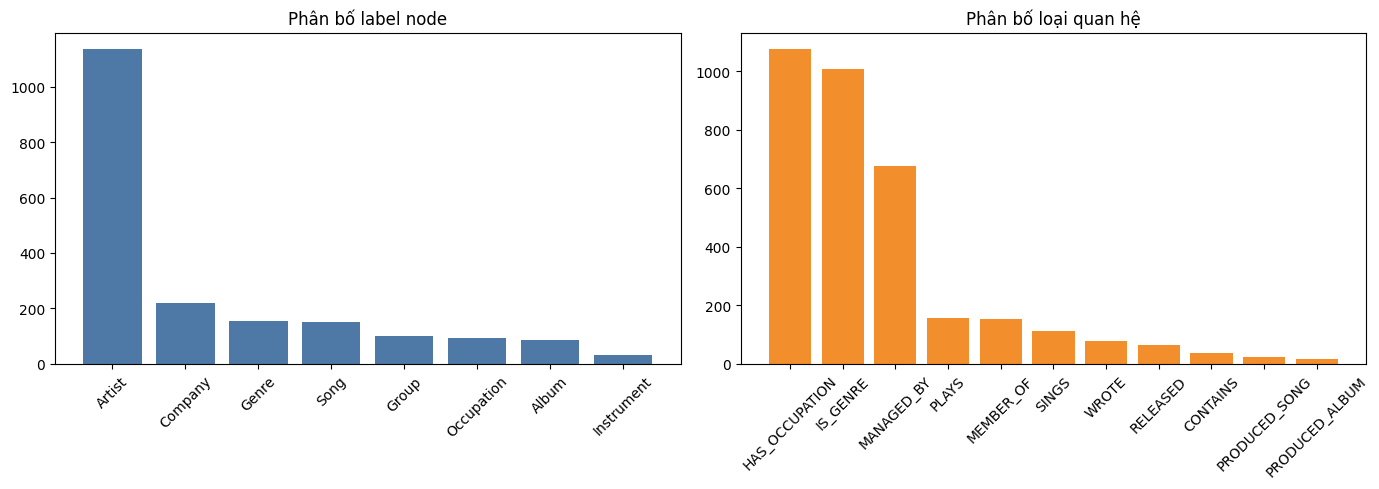

(     label  count
 1   Artist   1137
 4  Company    218
 5    Genre    156
 3     Song    150
 0    Group    100,
               type  count
 7   HAS_OCCUPATION   1077
 9         IS_GENRE   1006
 8       MANAGED_BY    675
 10           PLAYS    158
 0        MEMBER_OF    155)

In [2]:
# Thống kê theo label và loại cạnh
label_counts = Counter([node.get('label', 'Unknown') for node in nodes.values()])
edge_type_counts = Counter([e.get('type', 'RELATED_TO') for e in edges])

label_df = pd.DataFrame(label_counts.items(), columns=['label', 'count']).sort_values('count', ascending=False)
edge_df = pd.DataFrame(edge_type_counts.items(), columns=['type', 'count']).sort_values('count', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(label_df['label'], label_df['count'], color='#4E79A7')
axes[0].set_title('Phân bố label node')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(edge_df['type'], edge_df['count'], color='#F28E2B')
axes[1].set_title('Phân bố loại quan hệ')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

label_df.head(), edge_df.head()


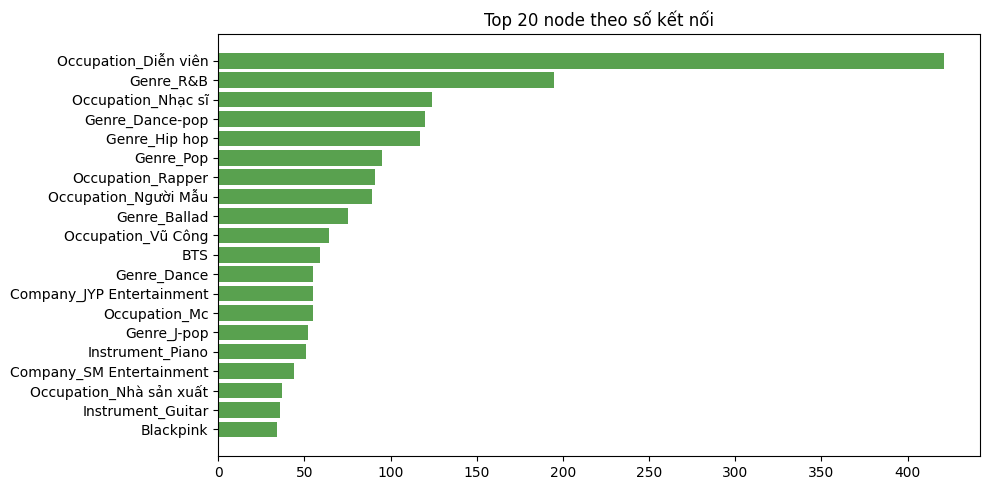

In [3]:
# Top node theo độ kết nối (nếu networkx khả dụng)
if nx is not None:
    G = nx.Graph()
    for key, n in nodes.items():
        G.add_node(key, **n)
    for e in edges:
        s, t = e.get('source'), e.get('target')
        if s in nodes and t in nodes:
            G.add_edge(s, t, **e)

    deg = dict(G.degree())
    top_deg = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:20]
    top_df = pd.DataFrame(top_deg, columns=['node', 'degree'])
    top_df['label'] = top_df['node'].map(lambda k: nodes[k].get('label'))

    plt.figure(figsize=(10,5))
    plt.barh(top_df['node'][::-1], top_df['degree'][::-1], color='#59A14F')
    plt.title('Top 20 node theo số kết nối')
    plt.tight_layout()
    plt.show()

    top_df.head(10)
else:
    print('networkx chưa cài, bỏ qua bước tính độ.')


In [4]:
# Thống kê đã có sẵn (nếu script đã ghi) + tổng hợp nhanh
if stats:
    display(pd.Series(stats['basic']).rename('basic'))
    display(pd.Series(stats.get('connectivity', {})).rename('connectivity'))

# Tạo bảng label và edge top 10
print('\nTop label:')
display(label_df.head(10))
print('\nTop edge types:')
display(edge_df.head(10))


node_count    1974
edge_count    3403
Name: basic, dtype: int64

avg_degree      3.423506
max_degree    421.000000
min_degree      0.000000
density         0.001748
Name: connectivity, dtype: float64


Top label:


,label,count
1,Artist,1137
4,Company,218
5,Genre,156
3,Song,150
0,Group,100
7,Occupation,94
2,Album,86
6,Instrument,33



Top edge types:


,type,count
7,HAS_OCCUPATION,1077
9,IS_GENRE,1006
8,MANAGED_BY,675
10,PLAYS,158
0,MEMBER_OF,155
1,SINGS,112
5,WROTE,78
2,RELEASED,63
6,CONTAINS,39
4,PRODUCED_SONG,22
